# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### Для ускорения работы конвертируем excel файл в csv

In [2]:
xls = pd.ExcelFile('geo.xlsx')
data = xls.parse(sheetname="Sheet1", index_col=None, na_values=['NA'])
data.to_csv('geo.csv')

In [3]:
data = pd.read_csv('geo.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,x,y,comment_class
0,0,0,37.612416,55.777454,-1
1,1,1,37.612416,55.777454,-1
2,2,2,37.603298,55.742108,-1
3,3,3,37.558526,55.728758,-1
4,4,4,37.566431,55.731794,-1


In [4]:
data.shape

(108806, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     108806 non-null  int64  
 1   Unnamed: 0.1   108806 non-null  int64  
 2   x              108806 non-null  float64
 3   y              108806 non-null  float64
 4   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 4.2 MB


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [7]:
# нормализуем данные
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['x','y']])

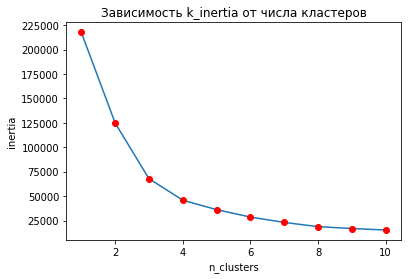

In [8]:
# подбираем оптимальное количество кластеров
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_scaled)
    k_inertia.append(clf_kmeans.inertia_)
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')
plt.title('Зависимость k_inertia от числа кластеров')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

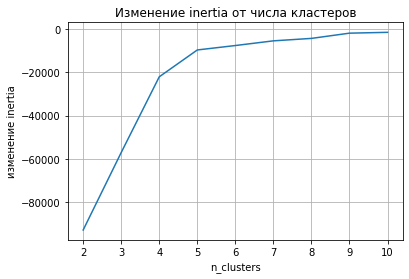

In [9]:
# Посмотрим изменение inertia

diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)
plt.title('Изменение inertia от числа кластеров')
plt.xlabel('n_clusters')
plt.ylabel('изменение inertia')
plt.grid()

$${inertia_{k+1}-inertia_{k}}$$

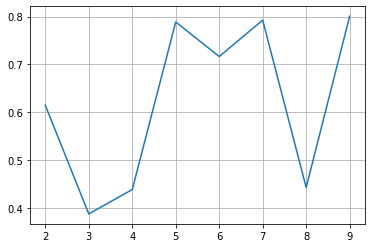

In [10]:
# Найдем оптимальное число кластеров

diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.grid()

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [11]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

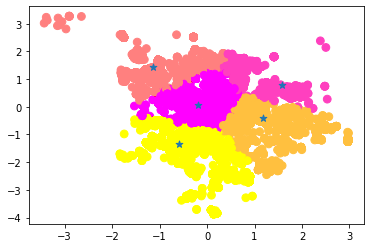

In [12]:
# Оптимальное число кластеров по формуле = 3, но глядя на график Зависимости k_inertia от числа кластеров, лучше возьмем 5

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], cmap='spring', c=clusters, s=60)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()

In [13]:
silhouette_score(data_scaled, clusters)

0.5187251573923971

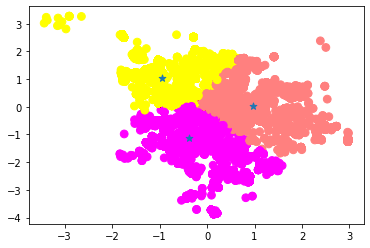

In [14]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], cmap='spring', c=clusters, s=60)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()

In [15]:
silhouette_score(data_scaled, clusters)

0.48094613471261816

#### Посмотрим кластеризацию для голосов за и против отдельно. Для этого разобъем данные на два датасета.

In [16]:
data_yes = data[data['comment_class'] == 1]
data_no = data[data['comment_class'] == -1]

In [17]:
data_yes.shape

(13659, 5)

In [18]:
data_no.shape

(95147, 5)

In [19]:
data_yes_scaled = scaler.fit_transform(data_yes[['x','y']])
data_no_scaled = scaler.fit_transform(data_no[['x','y']])

k_inertia_yes = []
k_inertia_no = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    
    clusters_kmeans_yes = clf_kmeans.fit_predict(data_yes_scaled)
    k_inertia_yes.append(clf_kmeans.inertia_)
    
    clusters_kmeans_no = clf_kmeans.fit_predict(data_no_scaled)
    k_inertia_no.append(clf_kmeans.inertia_)



KeyboardInterrupt: 

In [ ]:
plt.plot(ks, k_inertia_yes)
plt.plot(ks, k_inertia_no)
plt.plot(ks, k_inertia_yes ,'ro')
plt.plot(ks, k_inertia_no ,'ro')
plt.title('Зависимость k_inertia от числа кластеров')
plt.xlabel('n_clusters')
plt.ylabel('k_inertia')
plt.legend(['Positive reviews', 'Negative reviews'])
plt.show()

In [ ]:
# Используем 4 кластера для положительных отзывов

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(data_yes_scaled)
centers = kmeans.cluster_centers_
plt.scatter(data_yes_scaled[:, 0], data_yes_scaled[:, 1], cmap='spring', c=clusters, s=60)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()

In [ ]:
# Используем 4 кластера для отрицательных отзывов

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(data_no_scaled)
centers = kmeans.cluster_centers_
plt.scatter(data_no_scaled[:, 0], data_no_scaled[:, 1], cmap='spring', c=clusters, s=60)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()